<center><h1> graphical and numerical for solar-lasso comparison </h1></center>

---

## Check the following before running the code

### (a) Read "Read_Me_First.pdf" first, which introduces the package

### (b) Before replication, delete all .p files in the "./numerical_result" folder. The .p files record the numerical results of the our computation.

### (c) To avoid confusion, reset your kernel before you running the notebook (to clear memory): Menu "Kernel" $\rightarrow$ "Restart Kernel and clear all outputs".

### (d) To evaluate the code for simulation replication,
* <font size="4.5"> click : Menu "Kernel" $\rightarrow$ "Restart Kernel and Run All Cells" </font>
* <font size="4.5"> or, select a cell of code, press "shift" and "enter". Run all cells to avoid errors </font>

### (e) Check "joblib", "scikit-learn", "numpy", "matplotlib" and "tqdm" are installed. If not,
* <font size="4.5"> run "pip install joblib scikit-learn numpy matplotlib tqdm" in terminal (Mac OS or Linux) or command prompt as administrator (Windows) if you use Python3 without any IDE. </font>
* <font size="4.5"> we highly recommend installing Anaconda3 version 2020-11 directly to avoid package management (all packages mentioned above are installed by default).</font>

---

## #1: import all modules

* <font size="4.5"> "pickle" is used to save all computation results into ".p" files, which can be loaded later. </font>

* <font size="4.5"> For simplicity and elegancy, all relevant functions and classes are coded in "simul_plot.py". </font>

In [1]:
%reset -f

import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import pickle
import os
import errno
import mkl
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from pathlib    import Path
from simul_plot import simul_plot

## make sure we use the Intel MKL C++/Fortran compiler for maximum performance.

In [2]:
mkl.get_version_string()

'Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications'

In [3]:
print('The results in this file are obtained using the following mkl configuration:')

np.show_config()

The results in this file are obtained using the following mkl configuration:
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/ning/anaconda3/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/ning/anaconda3/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/ning/anaconda3/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/ning/anaconda3/include']
Supported SIMD extensions in this NumPy ins

---

## #2: define all functions

* <font size="4.5"> in this simulation, we use CV-lars-lasso (lasso solved by CV-lars) and CV-cd (lasso solved by warm-start, pathwise cylindrical coordinate descent) as the competitors </font>

## #2(a): compute of the solar, cv-lars and cv-cd and plot the results

In [4]:
def func_simul(sample_size, n_dim, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro):
  
    #set random seed
    np.random.seed(rnd_seed)

    #call function from the class
    trial = simul_plot(sample_size, n_dim, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on)

    #define the name of pickle file
    pkl_file = "./numerical_result/solar_graph_n_"+str(sample_size)+".p"

    if repro == True:  
        print("compute the simulation with sample size "+str(sample_size)+" and number of variables "+str(n_dim))

        #compute the result
        opt_c_stack, Q_opt_c_stack, la_array_stack, la_var_stack, solar_coef_stack, cd_array_stack, cd_var_stack = trial.simul_func()  

        #create the subdirectory if not existing
        if not os.path.exists(os.path.dirname(pkl_file)):
            try:
                os.makedirs(os.path.dirname(pkl_file))
            # Guard against race condition
            except OSError as exc: 
                if exc.errno != errno.EEXIST:
                    raise      

        with open(pkl_file, "wb") as f:
            pickle.dump( opt_c_stack      , f)
            pickle.dump( Q_opt_c_stack    , f)
            pickle.dump( la_array_stack   , f)
            pickle.dump( la_var_stack     , f)
            pickle.dump( cd_array_stack   , f)
            pickle.dump( cd_var_stack     , f)
            pickle.dump( solar_coef_stack , f)


    else:
        with open(pkl_file, "rb") as f:
            opt_c_stack      = pickle.load( f )
            Q_opt_c_stack    = pickle.load( f )
            la_array_stack   = pickle.load( f )
            la_var_stack     = pickle.load( f )
            cd_array_stack   = pickle.load( f )
            cd_var_stack     = pickle.load( f )
            solar_coef_stack = pickle.load( f )

    if not os.path.exists("figure"):
        os.mkdir("figure")

    #set random seed
    np.random.seed(rnd_seed)

    #plot the hist of number of variables selected of solar, cv-lars-lasso and cv-cd
    trial.vari_hist(Q_opt_c_stack, la_array_stack, cd_array_stack)

    #plot the optimal q value for all num_rep solar repeatations
    trial.q_hist(opt_c_stack)

    #plot the probability of each variable be selected by solar, cv-lars-lasso and cv-cd
    print_true_1 = False
    print_true_2 = True

    num_var_to_plot_1 = 15
    ##this is the maximum number of variables that can be plot in one graph

    trial.acc_plot(Q_opt_c_stack, la_var_stack, cd_var_stack, 20, print_true_1)
    trial.acc_plot(Q_opt_c_stack, la_var_stack, cd_var_stack, 20, print_true_2)
    trial.bl_vari_plot(solar_coef_stack, num_var_to_plot_1)     

## #2(b):summarize all the results into a table for better comparison

In [5]:
def sum_table(sample_size, n_dim, num_rep, plot_on):
  
    #read all raw results
    pkl_file = "./numerical_result/solar_graph_n_"+str(sample_size)+".p"

    with open(pkl_file, "rb") as f:
        opt_c_stack      = pickle.load( f )
        Q_opt_c_stack    = pickle.load( f )
        la_array_stack   = pickle.load( f )
        la_var_stack     = pickle.load( f )
        cd_array_stack   = pickle.load( f )
        cd_var_stack     = pickle.load( f )
        solar_coef_stack = pickle.load( f )

    if not os.path.exists("table"):
        os.mkdir("table")

    #compute the number of selected variable of solar, cv-lars-lasso and cv-cd
    ## set the container
    solar_len_array  = np.empty([len(solar_coef_stack)])
    cvlars_len_array = np.empty([len(solar_coef_stack)])
    cvcd_len_array   = np.empty([len(solar_coef_stack)])
    ##count the number 
    for i in range(len(Q_opt_c_stack)):
        solar_len_array[i]  = len(Q_opt_c_stack[i])
        cvlars_len_array[i] = la_array_stack[i]
        cvcd_len_array[i]   = cd_array_stack[i]

    #compute the marginal probability of selecting each informative variable
    ## set the container
    solar_var_array  = np.empty([5])
    cvlars_var_array = np.empty([5])
    cvcd_var_array   = np.empty([5])
    ##concatenate results
    solar_vari_appe_stack  = np.concatenate(Q_opt_c_stack,0)
    cvlars_vari_appe_stack = np.concatenate(la_var_stack,0)
    cvcd_vari_appe_stack   = np.concatenate(cd_var_stack,0)
    ##count the number
    for i in range(5):
        solar_var_array[i]  = (solar_vari_appe_stack  == i).sum()/num_rep
        cvlars_var_array[i] = (cvlars_vari_appe_stack == i).sum()/num_rep
        cvcd_var_array[i]   = (cvcd_vari_appe_stack   == i).sum()/num_rep

    #sparsity table
    mean_col   = [np.mean(solar_len_array), np.mean(cvlars_len_array), np.mean(cvcd_len_array)]
    median_col = [np.median(solar_len_array), np.median(cvlars_len_array), np.median(cvcd_len_array)]
    IQR_col    = [np.quantile(solar_len_array, 0.75)-np.quantile(solar_len_array, 0.25),
                  np.quantile(cvlars_len_array, 0.75)-np.quantile(cvlars_len_array, 0.25), 
                  np.quantile(cvcd_len_array, 0.75)-np.quantile(cvcd_len_array, 0.25)]

    df1 = pd.concat([pd.DataFrame({'algo':['solar','cvlars', 'cvcd']}), 
                     pd.DataFrame({'Number of selected variables (mean)': mean_col}),
                     pd.DataFrame({'Number of selected variables (median)': median_col}),
                     pd.DataFrame({'Number of selected variables (IQR)': IQR_col})], 
                    axis=1, join='inner')

    #accuracy table
    prob_0 = [solar_var_array[0], cvlars_var_array[0], cvcd_var_array[0]]
    prob_1 = [solar_var_array[1], cvlars_var_array[1], cvcd_var_array[1]]
    prob_2 = [solar_var_array[2], cvlars_var_array[2], cvcd_var_array[2]]
    prob_3 = [solar_var_array[3], cvlars_var_array[3], cvcd_var_array[3]]
    prob_4 = [solar_var_array[4], cvlars_var_array[4], cvcd_var_array[4]]

    df2 = pd.concat([pd.DataFrame({'algo':['solar','cvlars', 'cvcd']}), 
                     pd.DataFrame({'Pr(select X1)': prob_0}),
                     pd.DataFrame({'Pr(select X1)': prob_1}),
                     pd.DataFrame({'Pr(select X1)': prob_2}),
                     pd.DataFrame({'Pr(select X1)': prob_3}),
                     pd.DataFrame({'Pr(select X1)': prob_4})],
                    axis=1, join='inner')

    return df1.round(1), df2.round(1)

---

## #3(a): define inputs values

| <font size="4.5"> variable name </font> | <font size="4.5">  meaning </font> |
|-|-|
| <font size="4.5">  sample_size  </font> | <font size="4.5">  the sample size $n$ in the paper; </font>| 
| <font size="4.5">  n_dim        </font> | <font size="4.5">  the number of variables (informative + redundant) in $X$, $p$ in the paper; </font>| 
| <font size="4.5">  n_info       </font> | <font size="4.5">  the number of informative variables in $X$; </font>| 
| <font size="4.5">  n_repeat     </font> | <font size="4.5">  the number of subsamples generated by solar; </font>| 
| <font size="4.5">  num_rep      </font> | <font size="4.5">  the total repetition number of this simulation; </font>|
| <font size="4.5">  step_size    </font> | <font size="4.5">  the step size for tuning $c$; </font>| 
| <font size="4.5">  rnd_seed     </font> | <font size="4.5">  the random seed value; </font>| 

### #3(b): define DGP

* <font size="4.5"> the population regression equation is $$Y = 2\cdot \mathbf{x}_0 + 3\cdot \mathbf{x}_1 + 4\cdot \mathbf{x}_2 + 5\cdot \mathbf{x}_3 + 6\cdot \mathbf{x}_4  + u,$$ 
* <font size="4.5"> To change the simulation settings, simply change the input values. If you change *n_info* you will adjust the DGP as follows: </font>
    * <font size="4.5"> If $i > \mbox{n_info} - 1$ and $i \in \left[ 0, 1, 2, \ldots, p-1 \right]$, $\beta_i = 0$ in population;</font>
    * <font size="4.5"> If $i \leqslant \mbox{n_info} - 1$ and $i \in \left[ 0, 1, 2, \ldots, p-1 \right]$, $\beta_i = i + 2$ in population</font>

In [6]:
n_dim       = 100
n_info      = 5 
step_size   = -0.01 
n_repeat    = 3
num_rep     = 200
rnd_seed    = 0

sample_size_0 = 100
sample_size_1 = 150
sample_size_2 = 200

## If you want to save the plots and tables locally, please change the *plot_on* value to True

In [7]:
plot_on = False

* <font size="5"> If you want to replicate the result, set the "repro" value to True; </font>
* <font size="5"> *repro=True* will report our result saved at ".p" files; </font>

In [8]:
repro = True

---

## #4: compute solar, CV-lars-lasso and CV-cd

### This applies for replication only (numerical results will be saved as .p files) and can be skipped if you have already computed simulation results.

### Numpy, sklearn and python are actively updated. If you use different version, replication results may be slightly different from the paper (see Read_me_first.pdf for detail).

### To rerun this part, first delete all .p files in your working folder to avoid possible bug.

# scenario #1: $p/n \rightarrow 0$

## $n = 100, p =100$

### plot the results

<font size="4.5"> The available results are: </font>

* <font size="4.5"> histogram of number of variables selected by solar, CV-cd and CV-lars-lasso; </font>
* <font size="4.5"> histogram of optimal $c$ value for $\left\{ \mathbf{x}_j \; \vert \; \widehat{q}_j \geqslant c \right\}$ in all 200 repetitions of solar computation on different samples; </font>
* <font size="4.5"> probability of selecting each redundant variable in solar, CV-cd and CV-lars-lasso (top 15 by probability); </font>
* <font size="4.5"> probability of selecting each informative variable in solar, CV-cd and CV-lars-lasso; </font>
* <font size="4.5"> the boxplot of regression coefficients of solar (top 15 means); </font>

compute the simulation with sample size 100 and number of variables 100


100%|██████████| 200/200 [01:13<00:00,  2.73it/s]


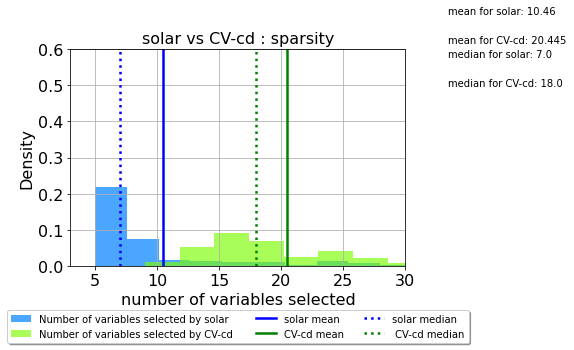

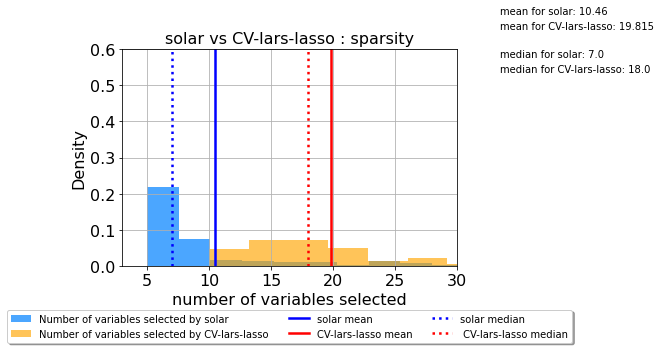

in 159 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


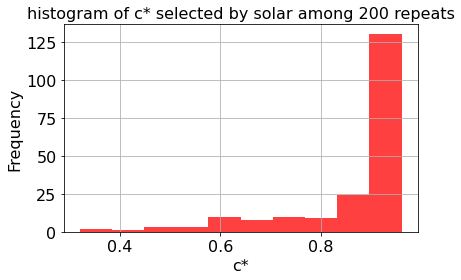

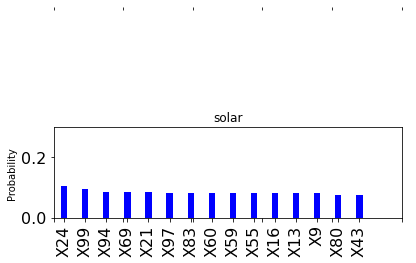

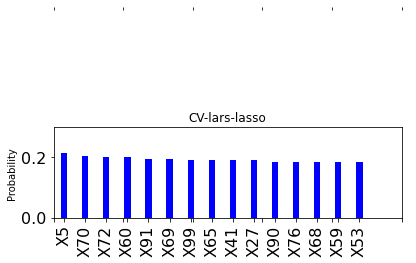

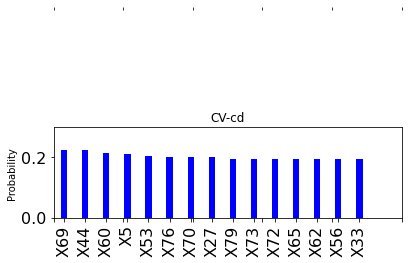

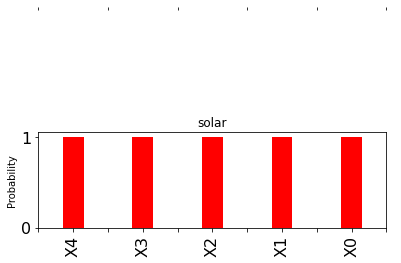

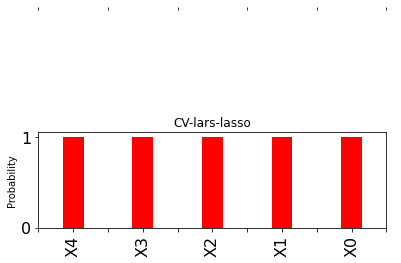

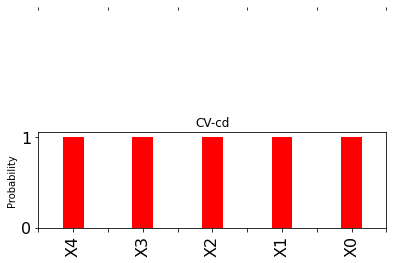

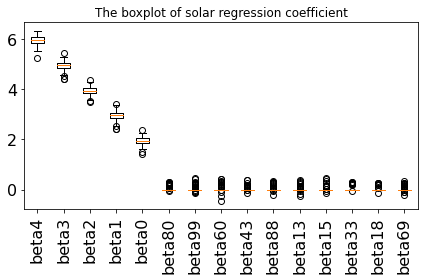

the number of non-zeros in the boxplot of beta_0:  200
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [9]:
func_simul(sample_size_0, n_dim, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now let's summarize the results into a table

In [10]:
df1, df2 = sum_table(sample_size_0, n_dim, num_rep, plot_on)

In [11]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,10.5,7.0,5.0
1,cvlars,19.8,18.0,7.0
2,cvcd,20.4,18.0,8.0


In [12]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---

## $n = 150, p =100$

compute the simulation with sample size 150 and number of variables 100


100%|██████████| 200/200 [00:53<00:00,  3.73it/s]


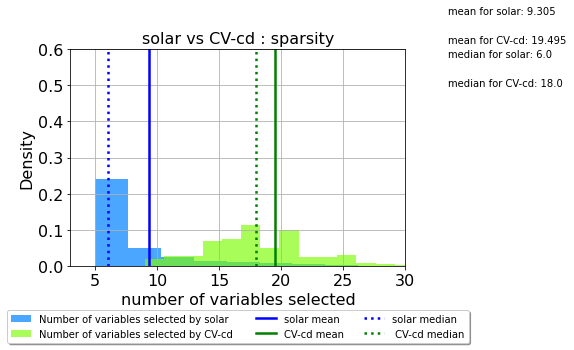

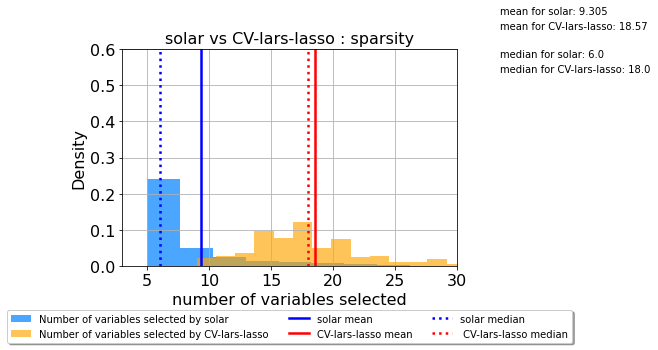

in 124 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


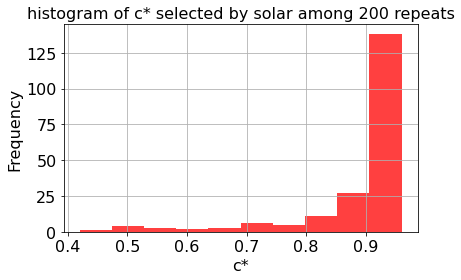

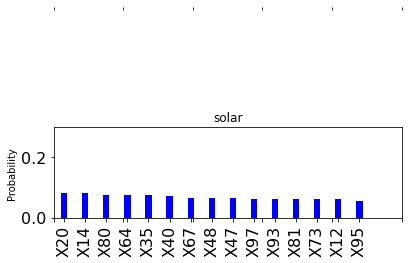

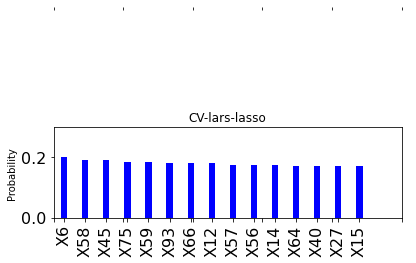

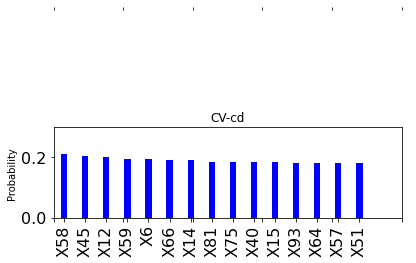

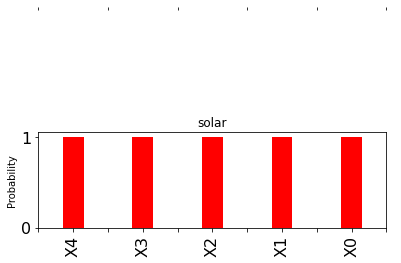

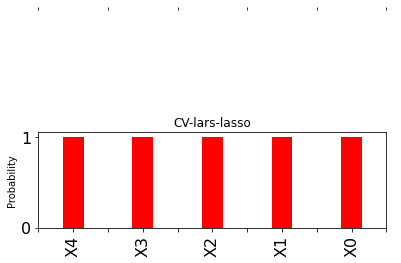

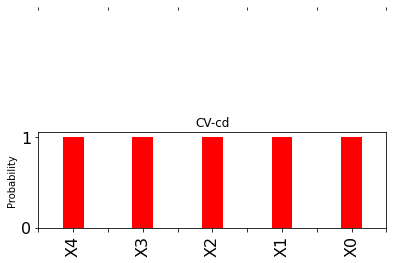

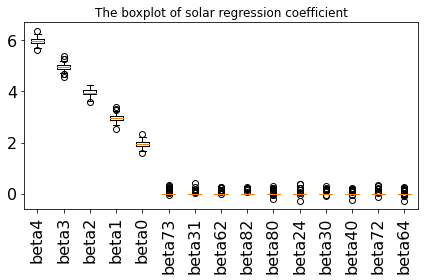

the number of non-zeros in the boxplot of beta_0:  200
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [13]:
func_simul(sample_size_1, n_dim, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now let's summarize the results into a table

In [14]:
df1, df2 = sum_table(sample_size_1, n_dim, num_rep, plot_on)

In [15]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,9.3,6.0,5.0
1,cvlars,18.6,18.0,6.0
2,cvcd,19.5,18.0,5.0


In [16]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---

## $n = 200, p =100$

compute the simulation with sample size 200 and number of variables 100


100%|██████████| 200/200 [00:48<00:00,  4.09it/s]


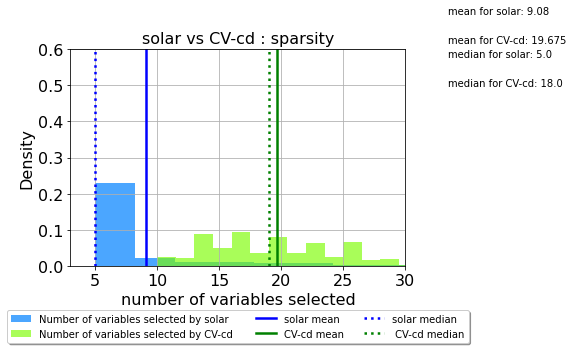

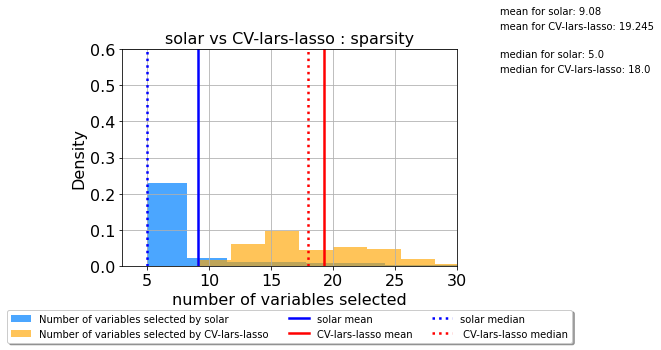

in 95 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


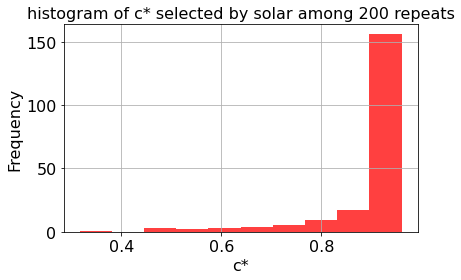

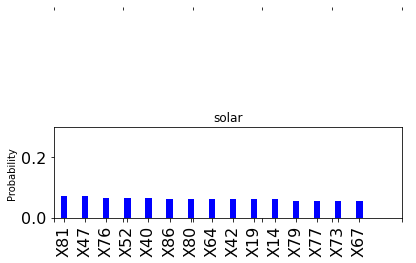

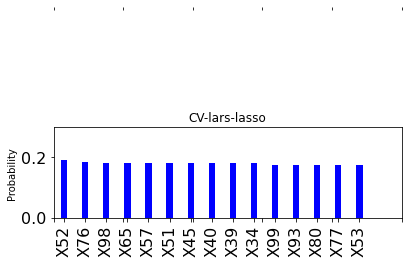

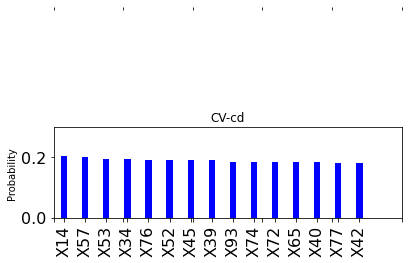

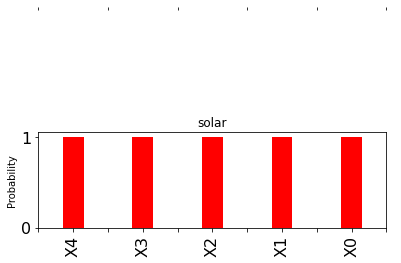

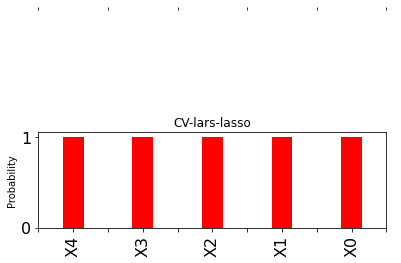

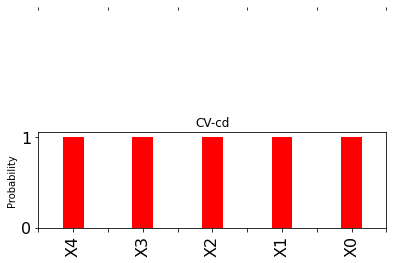

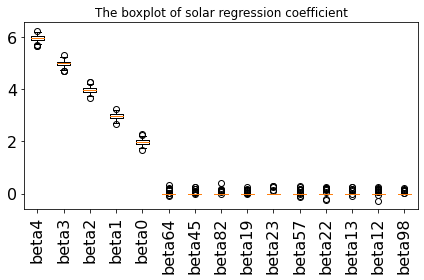

the number of non-zeros in the boxplot of beta_0:  200
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [17]:
func_simul(sample_size_2, n_dim, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now let's summarize the results into a table

In [18]:
df1, df2 = sum_table(sample_size_2, n_dim, num_rep, plot_on)

In [19]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,9.1,5.0,4.0
1,cvlars,19.2,18.0,8.0
2,cvcd,19.7,19.0,8.2


In [20]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---

# scenario #2: $p/n \rightarrow 1$

In [21]:
sample_size_0  = 100 ; n_dim_0 = 150
sample_size_1  = 150 ; n_dim_1 = 200
sample_size_2  = 200 ; n_dim_2 = 250

## $n = 100, p =150$

compute the simulation with sample size 100 and number of variables 150


100%|██████████| 200/200 [01:13<00:00,  2.71it/s]


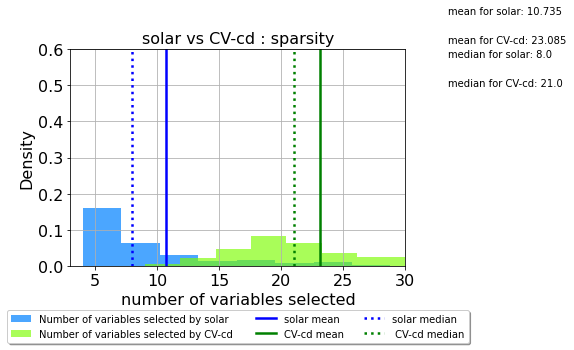

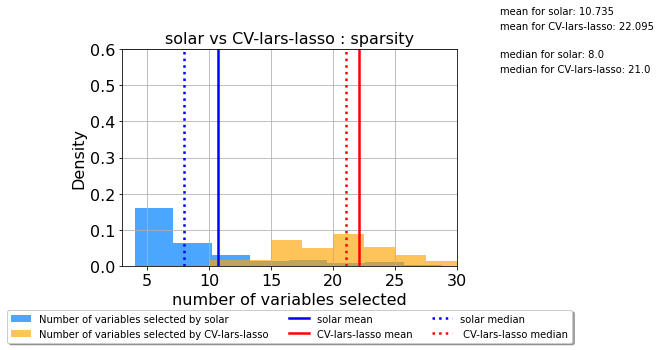

in 183 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


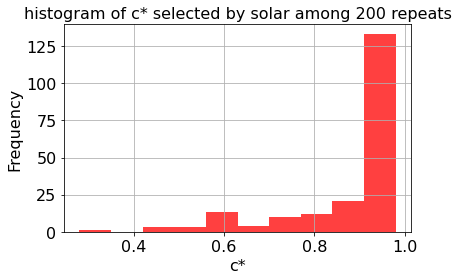

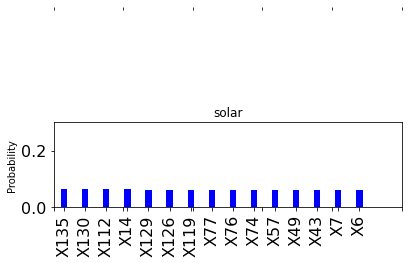

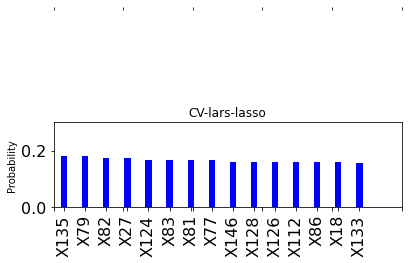

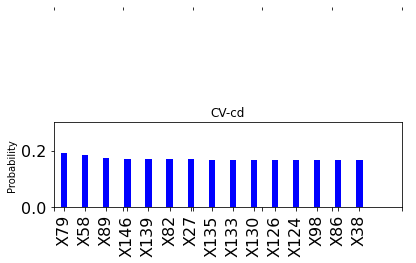

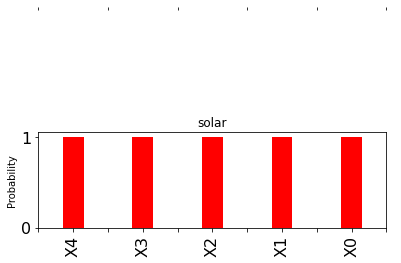

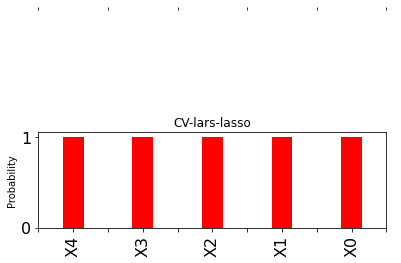

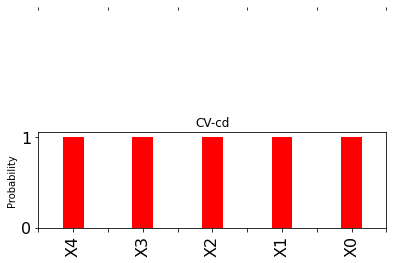

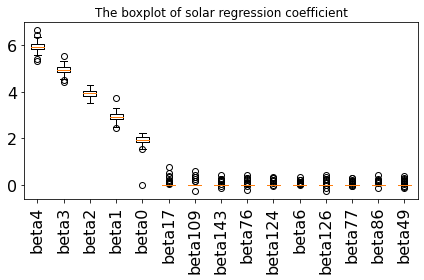

the number of non-zeros in the boxplot of beta_0:  199
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [22]:
func_simul(sample_size_0, n_dim_0, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now let's summarize the results into a table

In [23]:
df1, df2 = sum_table(sample_size_0, n_dim_0, num_rep, plot_on)

In [24]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,10.7,8.0,5.2
1,cvlars,22.1,21.0,8.0
2,cvcd,23.1,21.0,9.0


In [25]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---
## $n = 150, p =200$

compute the simulation with sample size 150 and number of variables 200


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


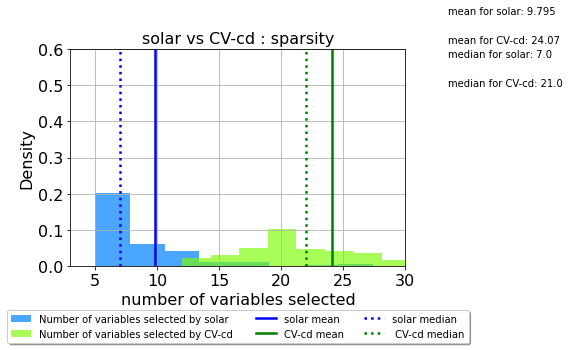

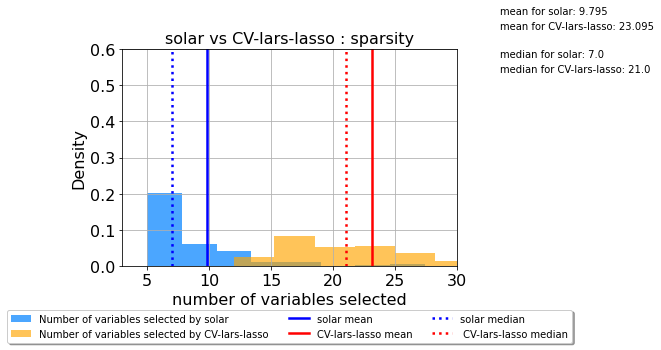

in 124 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


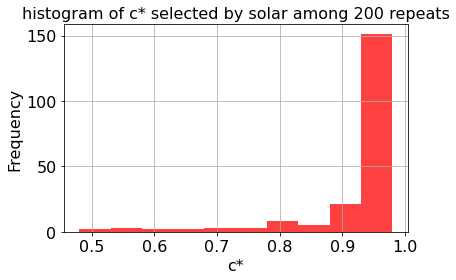

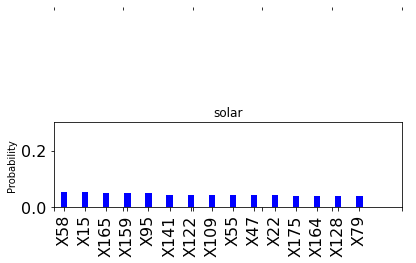

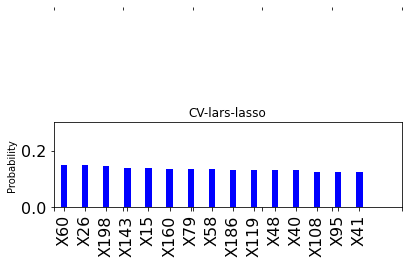

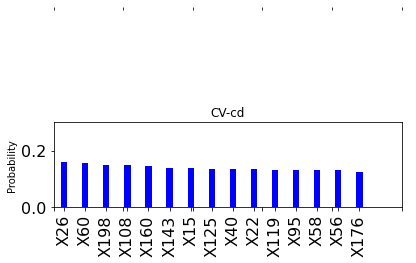

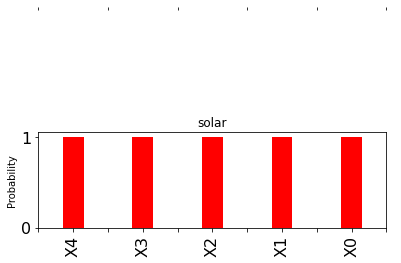

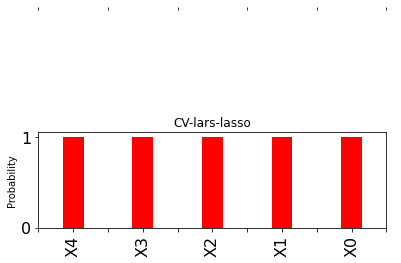

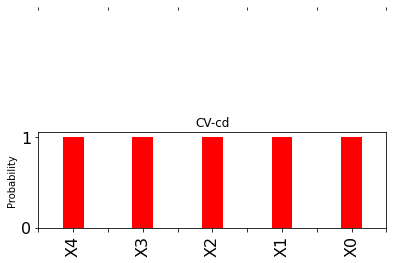

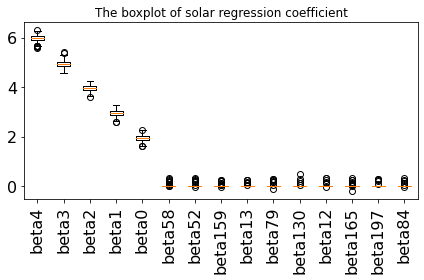

the number of non-zeros in the boxplot of beta_0:  200
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [26]:
func_simul(sample_size_1, n_dim_1, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now let's summarize the results into a table

In [27]:
df1, df2 = sum_table(sample_size_1, n_dim_1, num_rep, plot_on)

In [28]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,9.8,7.0,6.0
1,cvlars,23.1,21.0,9.0
2,cvcd,24.1,22.0,9.0


In [29]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---
## $n = 200, p =250$

compute the simulation with sample size 200 and number of variables 250


100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


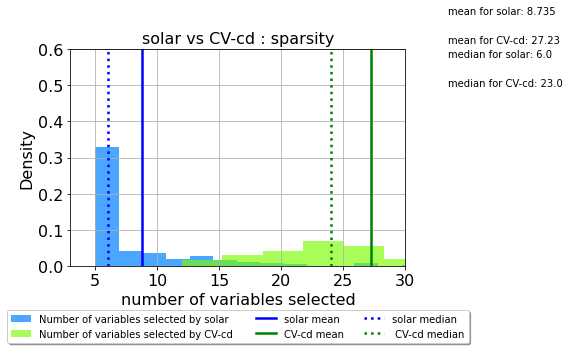

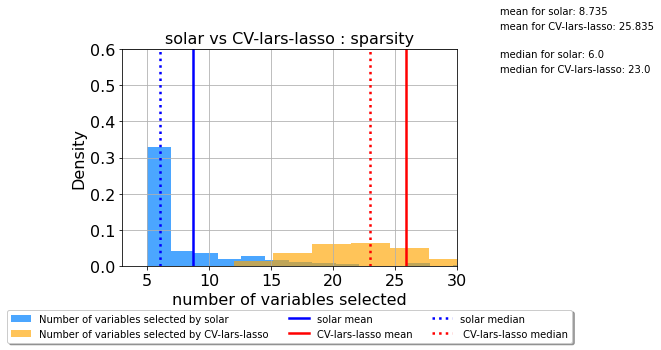

in 109 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


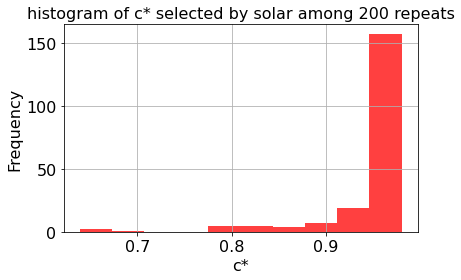

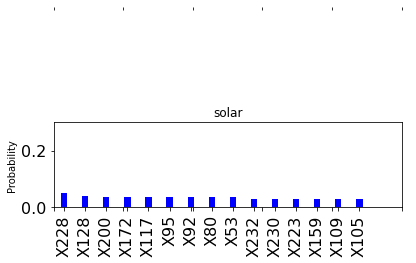

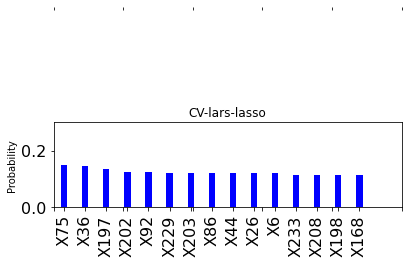

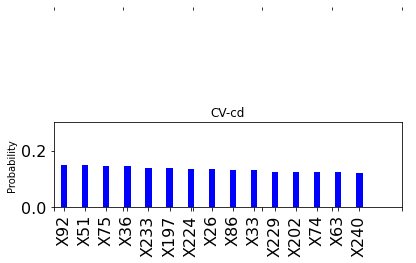

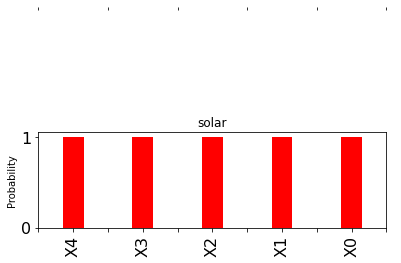

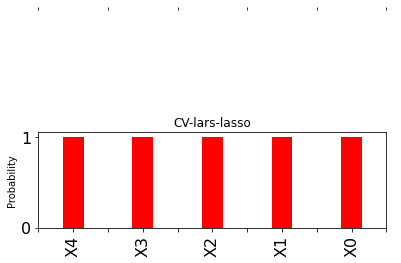

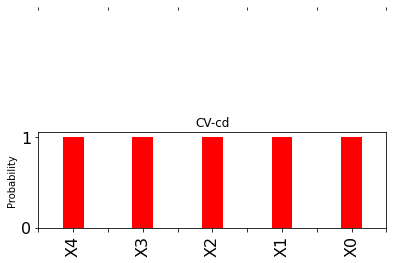

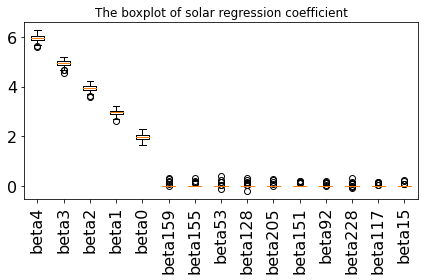

the number of non-zeros in the boxplot of beta_0:  200
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [30]:
func_simul(sample_size_2, n_dim_2, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now let's summarize the results into a table

In [31]:
df1, df2 = sum_table(sample_size_2, n_dim_2, num_rep, plot_on)

In [32]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,8.7,6.0,5.0
1,cvlars,25.8,23.0,9.0
2,cvcd,27.2,24.0,9.0


In [33]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---

# scenario #3: $\log(p)/n \rightarrow 0$

In [34]:
sample_size_0  = 200 ; n_dim_0 = 400
sample_size_1  = 400 ; n_dim_1 = 800
sample_size_2  = 600 ; n_dim_2 = 1200

## $n = 200, p =400$

compute the simulation with sample size 200 and number of variables 400


100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


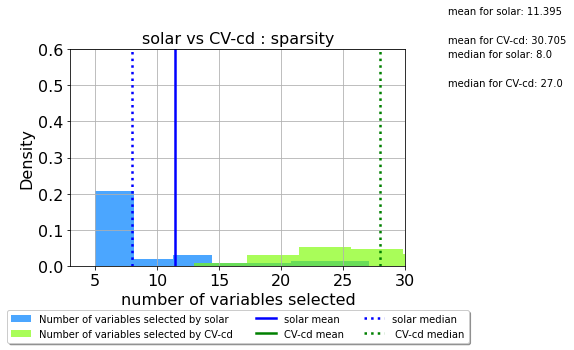

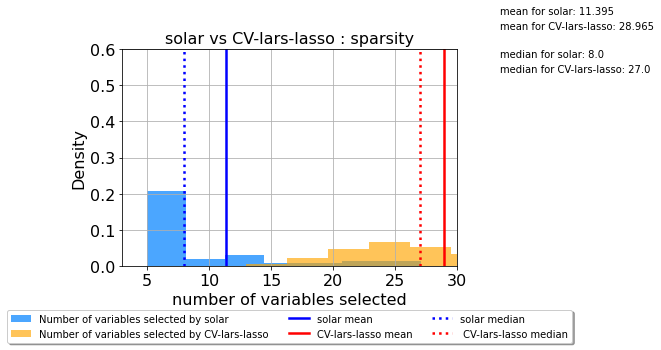

in 197 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


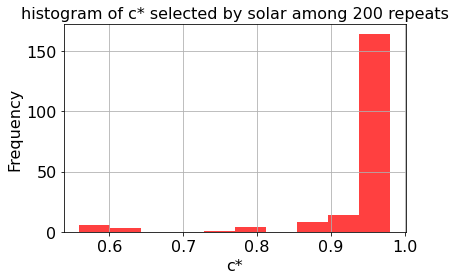

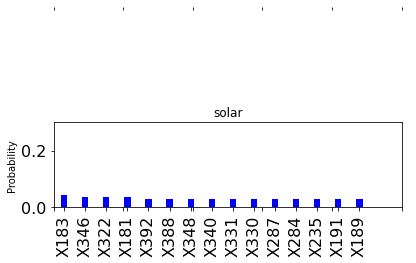

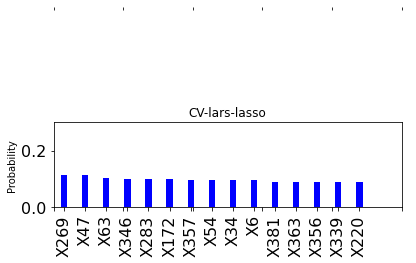

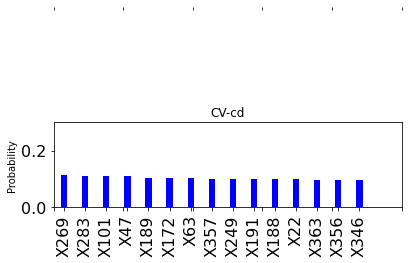

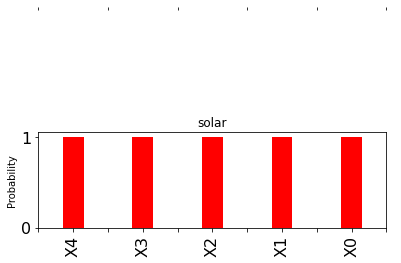

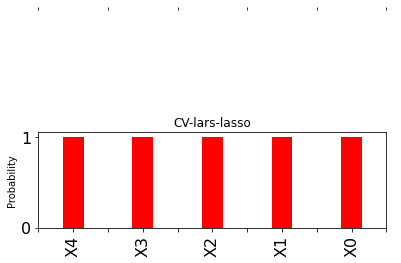

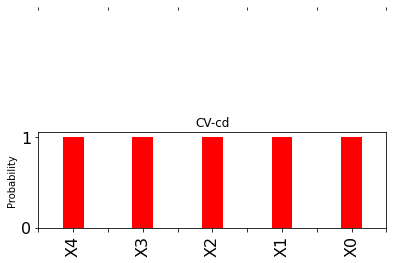

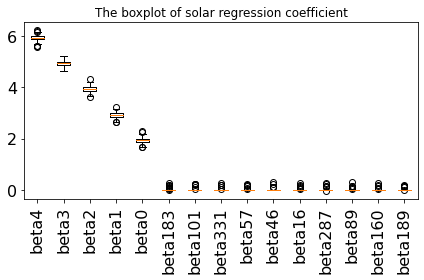

the number of non-zeros in the boxplot of beta_0:  200
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [35]:
func_simul(sample_size_0, n_dim_0, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now we summarize them in a table

In [36]:
df1, df2 = sum_table(sample_size_0, n_dim_0, num_rep, plot_on)

In [37]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,11.4,8.0,5.0
1,cvlars,29.0,27.0,10.0
2,cvcd,30.7,28.0,11.0


In [38]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---

## $n = 400, p = 800$

compute the simulation with sample size 400 and number of variables 800


100%|██████████| 200/200 [12:09<00:00,  3.65s/it]


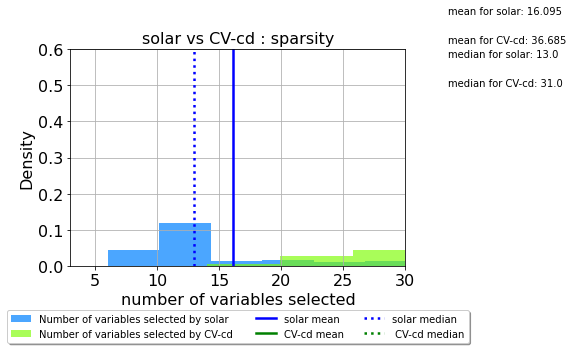

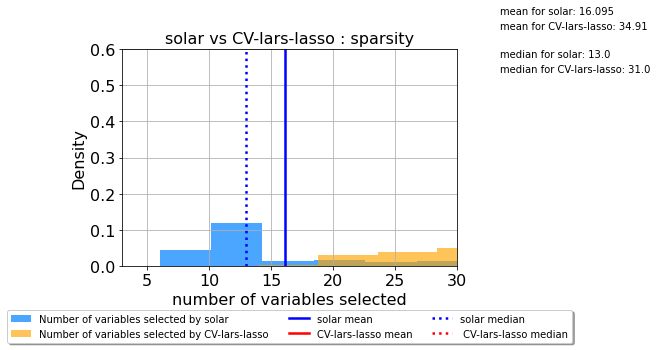

in 200 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


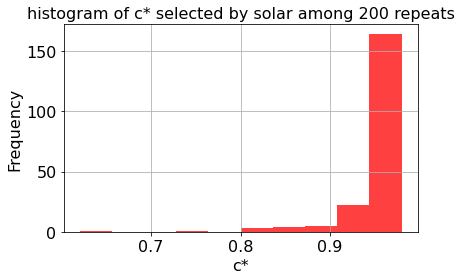

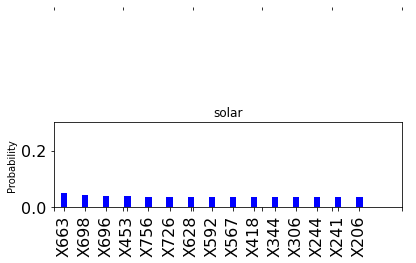

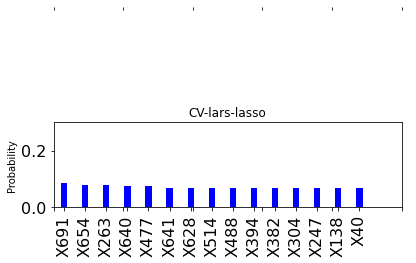

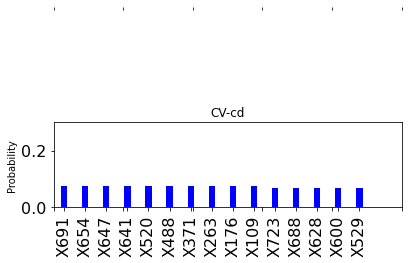

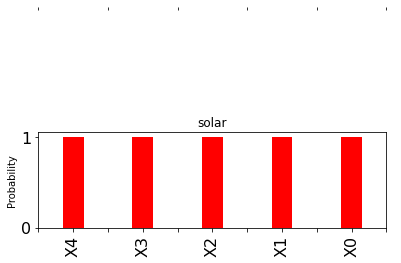

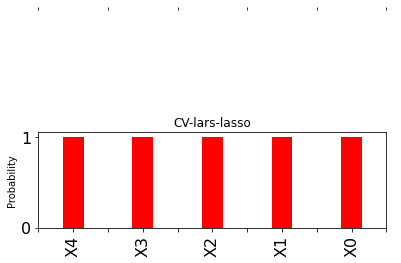

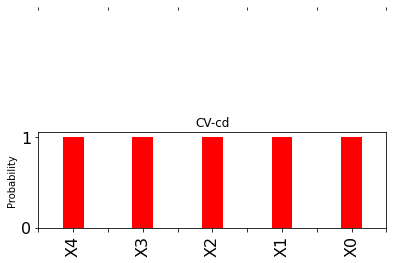

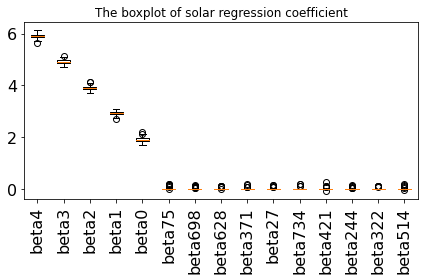

the number of non-zeros in the boxplot of beta_0:  200
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [39]:
func_simul(sample_size_1, n_dim_1, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now we summarize them in a table

In [40]:
df1, df2 = sum_table(sample_size_1, n_dim_1, num_rep, plot_on)

In [41]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,16.1,13.0,7.2
1,cvlars,34.9,31.0,12.0
2,cvcd,36.7,32.0,15.0


In [42]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---

## $n = 600, p = 1200$

compute the simulation with sample size 600 and number of variables 1200


100%|██████████| 200/200 [21:32<00:00,  6.46s/it]


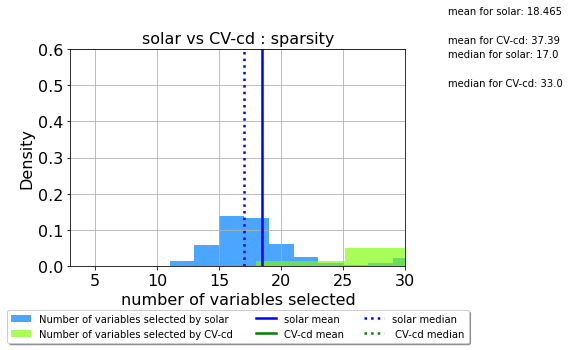

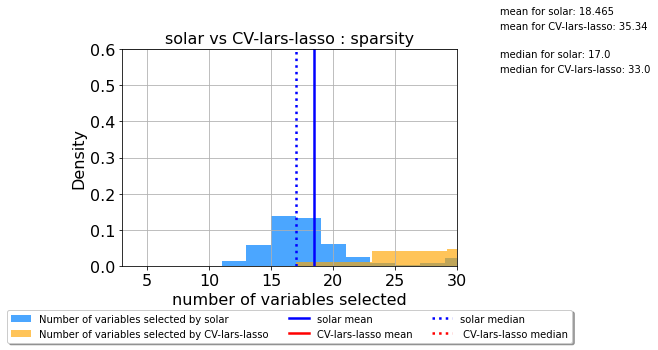

in 200 out of 200 solar pick more/less than 5 variables
in 200 out of 200 CV-lars-lasso pick more/less than 5 variables
in 200 out of 200 CV-cd pick more/less than 5 variables


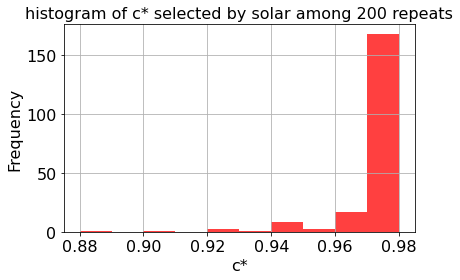

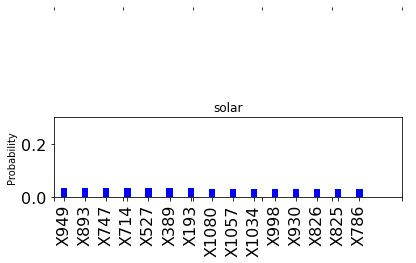

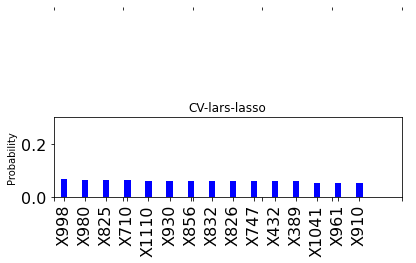

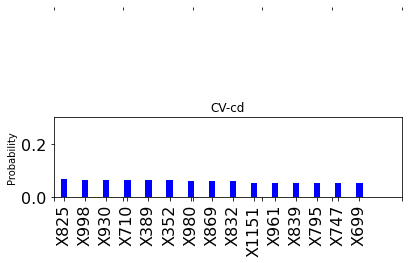

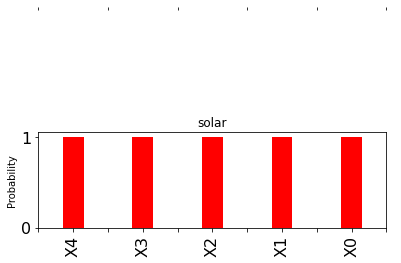

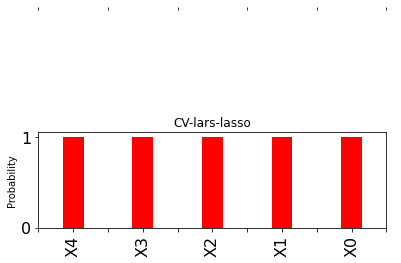

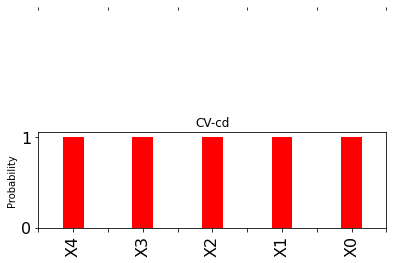

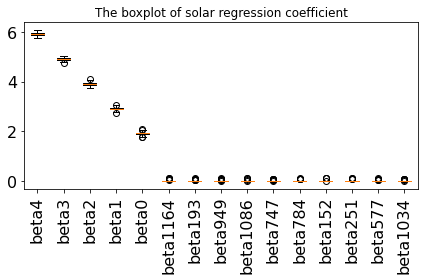

the number of non-zeros in the boxplot of beta_0:  200
the number of non-zeros in the boxplot of beta_1:  200
the number of non-zeros in the boxplot of beta_2:  200
the number of non-zeros in the boxplot of beta_3:  200
the number of non-zeros in the boxplot of beta_4:  200


In [43]:
func_simul(sample_size_2, n_dim_2, n_info, n_repeat, num_rep, step_size, rnd_seed, plot_on, repro)

## now we summarize them in a table

In [44]:
df1, df2 = sum_table(sample_size_2, n_dim_2, num_rep, plot_on)

In [45]:
df1

,algo,Number of selected variables (mean),Number of selected variables (median),Number of selected variables (IQR)
0,solar,18.5,17.0,4.0
1,cvlars,35.3,33.0,9.0
2,cvcd,37.4,34.0,12.0


In [46]:
df2

,algo,Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1),Pr(select X1)
0,solar,1.0,1.0,1.0,1.0,1.0
1,cvlars,1.0,1.0,1.0,1.0,1.0
2,cvcd,1.0,1.0,1.0,1.0,1.0


---

## Finally, let's produce the result into an HTML file

In [1]:
!rm -rf simul_solar_lasso.html
!jupyter nbconvert --to html simul_solar_lasso.ipynb

[NbConvertApp] Converting notebook simul_solar_lasso.ipynb to html
[NbConvertApp] Writing 2235454 bytes to simul_solar_lasso.html
